# **ĐỀ TÀI:** DỰ ĐOÁN NHIỆT ĐỘ HẰNG NGÀY
###**Mô tả:** Dự đoán nhiệt độ hằng ngày dựa trên chuỗi dữ liệu nhiệt độ những ngày trước đó, sử dụng bộ dữ liệu nhiệt độ tối thiểu hàng ngày từ 1981–1990. Dự án triển khai các mô hình học sâu gồm LSTM, Bidirectional LSTM, Deep LSTM, GRU và Custom LSTM (Keras-TensorFlow) để dự đoán. Dữ liệu được chuẩn hóa và chia thành tập huấn luyện (80%) và kiểm tra (20%), với chuỗi đầu vào 14 ngày. Các mô hình được huấn luyện với tối ưu hóa Adam, early stopping và dropout để tránh overfitting. Kết quả được đánh giá qua các chỉ số MAE, MSE, RMSE, R², và mô hình tốt nhất được chọn dựa trên MSE thấp nhất. Dự án cũng phân tích sai số và xác định các điểm ngoại lai bằng phương pháp IQR, trực quan hóa kết quả qua biểu đồ nhiệt độ, loss và sai số.
### **Dữ liệu:**
- Dữ liệu **Daily-Minimum-Temperatures.csv** (nguồn UCI Machine Learning Repository)

- Gồm 2 cột: **Date** và **Temp** (nhiệt độ tối thiểu hằng ngày tại Melbourne từ 1981–1990)

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [97]:
# 1. Phân tích dữ liệu gốc

# url = "/content/drive/MyDrive/thayvu/daily-min-temperatures.csv"
# df = pd.read_csv(url, parse_dates=['Date'])
# df.head()

url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [98]:
df.shape

(3650, 2)

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


In [100]:
df.describe()

,Date,Temp
count,3650,3650.000000
mean,1985-12-31 07:12:00,11.177753
min,1981-01-01 00:00:00,0.000000
25%,1983-07-02 06:00:00,8.300000
50%,1985-12-31 12:00:00,11.000000
75%,1988-06-30 18:00:00,14.000000
max,1990-12-31 00:00:00,26.300000
std,NaN,4.071837


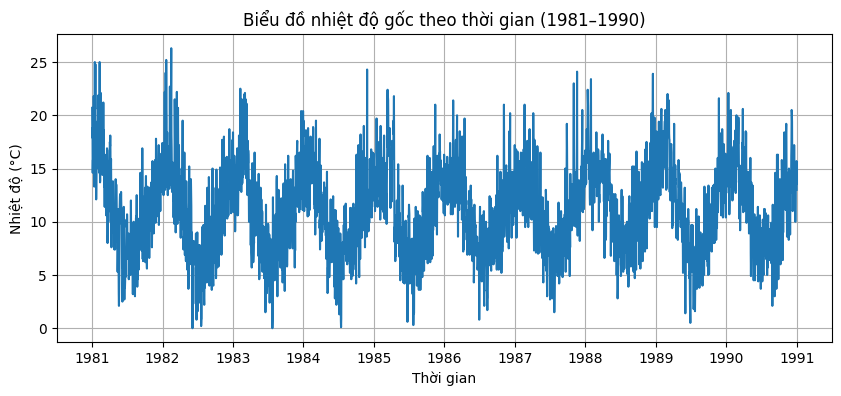

In [101]:
# Biểu đồ nhiệt độ gốc
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Temp'])
plt.title("Biểu đồ nhiệt độ gốc theo thời gian (1981–1990)")
plt.xlabel("Thời gian")
plt.ylabel("Nhiệt độ (°C)")
plt.grid()
plt.show()

Biểu đồ thể hiện biến thiên nhiệt độ tối thiểu hàng ngày từ năm 1981 đến 1990, cho thấy các dao động theo mùa rõ rệt với xu hướng nhiệt độ dao động từ khoảng 0°C đến 25°C. Các đỉnh cao thường xuất hiện vào mùa hè và đáy thấp vào mùa đông, phản ánh đặc điểm khí hậu có tính chu kỳ. Sự biến động mạnh trong dữ liệu gợi ý rằng mô hình dự đoán cần xử lý tốt các xu hướng thời gian và nhiễu ngẫu nhiên để đạt độ chính xác cao.

In [102]:
# 2. Tải và chuẩn hóa dữ liệu

data = df['Temp'].values.reshape(-1, 1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [103]:
# 3. Tạo chuỗi đầu vào

def create_sequences(data, seq_len):
    x, y = [], []
    for i in range(len(data) - seq_len):
        x.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(x), np.array(y)

SEQ_LEN = 14
X, y = create_sequences(data_scaled, SEQ_LEN)

In [104]:
# Chia train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**Chia train/test**

Chia dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%): X_train, y_train để huấn luyện mô hình; X_test, y_test để đánh giá hiệu suất và khả năng tổng quát hóa.

In [105]:
# 4. Xây dựng và huấn luyện mô hình
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Mô hình gốc (LSTM đơn layer)
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(0.001, clipnorm=1.0), loss='mse')
model_lstm.summary()  # Hiển thị cấu trúc mô hình
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0474 - val_loss: 0.0100
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0127 - val_loss: 0.0095
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0124 - val_loss: 0.0095
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0126 - val_loss: 0.0093
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0119 - val_loss: 0.0113
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0116 - val_loss: 0.0090
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0114 - val_loss: 0.0086
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0115 - val_loss: 0.0106
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0118 - val_loss: 0.0083
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107 - val_loss: 0.0082
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0

**kết quả huấn luyện LSTM**

Mô hình LSTM đơn layer với 64 units được huấn luyện trong 50 epochs, sử dụng early stopping khi val_loss không cải thiện sau 5 epochs. Loss giảm từ 0.0474 xuống 0.0096 và val_loss từ 0.0100 xuống 0.0072, cho thấy mô hình học tốt với sai số thấp và ổn định, không có dấu hiệu overfitting nhờ dropout 0.2.

In [106]:
# Mô hình Bidirectional LSTM
model_bilstm = Sequential([
    Bidirectional(LSTM(64, activation='tanh'), input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Dense(1)
])
model_bilstm.compile(optimizer=Adam(0.001, clipnorm=1.0), loss='mse')
model_bilstm.summary()  # Hiển thị cấu trúc mô hình
history_bilstm = model_bilstm.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,921 (132.50 KB)

 Trainable params: 33,921 (132.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0343 - val_loss: 0.0095
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0127 - val_loss: 0.0094
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0114 - val_loss: 0.0090
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0106 - val_loss: 0.0096
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0120 - val_loss: 0.0086
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0110 - val_loss: 0.0084
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0104 - val_loss: 0.0090
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0107 - val_loss: 0.0081
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0102 - val_loss: 0.0084
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0105 - val_loss: 0.0078
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0

**kết quả huấn luyện Bidirectional LSTM**

Mô hình Bidirectional LSTM với 64 units được huấn luyện trong 50 epochs, sử dụng early stopping. Loss giảm từ 0.0343 xuống 0.0092 và val_loss từ 0.0095 xuống 0.0072, cho thấy mô hình học hiệu quả với sai số ổn định, không có dấu hiệu overfitting nhờ dropout 0.2.

In [107]:
# Mô hình Deep LSTM
model_deep = Sequential([
    LSTM(64, activation='tanh', input_shape=(SEQ_LEN, 1), return_sequences=True),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
model_deep.compile(optimizer=Adam(0.001, clipnorm=1.0), loss='mse')
model_deep.summary()  # Hiển thị cấu trúc mô hình
history_deep = model_deep.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 14, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0416 - val_loss: 0.0102
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0140 - val_loss: 0.0100
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0132 - val_loss: 0.0098
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0133 - val_loss: 0.0096
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0128 - val_loss: 0.0094
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0125 - val_loss: 0.0093
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0135 - val_loss: 0.0093
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0125 - val_loss: 0.0088
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0120 - val_loss: 0.0092
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0108 - val_loss: 0.0085
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0111 - val_loss: 0.0081
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0

**kết quả huấn luyện Deep LSTM**

Mô hình Deep LSTM với 2 tầng (64 và 32 units) được huấn luyện trong 50 epochs, sử dụng early stopping. Loss giảm từ 0.0416 xuống 0.0096 và val_loss từ 0.0102 xuống 0.0073, cho thấy mô hình học hiệu quả, sai số thấp và không có dấu hiệu overfitting nhờ dropout 0.2.

In [108]:
# Mô hình GRU
model_gru = Sequential([
    GRU(64, activation='tanh', input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Dense(1)
])
model_gru.compile(optimizer=Adam(0.001, clipnorm=1.0), loss='mse')
model_gru.summary()  # Hiển thị cấu trúc mô hình
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0567 - val_loss: 0.0105
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0125 - val_loss: 0.0088
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0120 - val_loss: 0.0083
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0107 - val_loss: 0.0080
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0103 - val_loss: 0.0082
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0100 - val_loss: 0.0076
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0103 - val_loss: 0.0076
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0094 - val_loss: 0.0073
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0095 - val_loss: 0.0074
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0

**kết quả huấn luyện GRU**

Mô hình GRU với 64 units được huấn luyện trong 50 epochs, sử dụng early stopping. Loss giảm từ 0.0567 xuống 0.0092 và val_loss từ 0.0105 xuống 0.0071, cho thấy mô hình học hiệu quả, sai số thấp và ổn định, không có dấu hiệu overfitting nhờ dropout 0.2.

In [109]:
# Mô hình từ hình ảnh (LSTM đơn với 64 units)
model_custom = Sequential([
    LSTM(64, activation='tanh', input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    Dense(1)
])
model_custom.compile(optimizer=Adam(0.001, clipnorm=1.0), loss='mse')
model_custom.summary()  # Hiển thị cấu trúc mô hình
history_custom = model_custom.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0335 - val_loss: 0.0094
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0124 - val_loss: 0.0097
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0117 - val_loss: 0.0091
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0118 - val_loss: 0.0091
Epoch 6/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0111 - val_loss: 0.0086
Epoch 7/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0113 - val_loss: 0.0087
Epoch 8/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0116 - val_loss: 0.0083
Epoch 9/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0105 - val_loss: 0.0082
Epoch 10/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0113 - val_loss: 0.0081
Epoch 11/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0108 - val_loss: 0.0084
Epoch 12/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

**kết quả huấn luyện Custom LSTM**

Mô hình Custom LSTM với 64 units được huấn luyện trong 50 epochs, sử dụng early stopping. Loss giảm từ 0.0335 xuống 0.0092 và val_loss từ 0.0094 xuống 0.0072, cho thấy mô hình học tốt, sai số thấp và ổn định, không có dấu hiệu overfitting nhờ dropout 0.2.

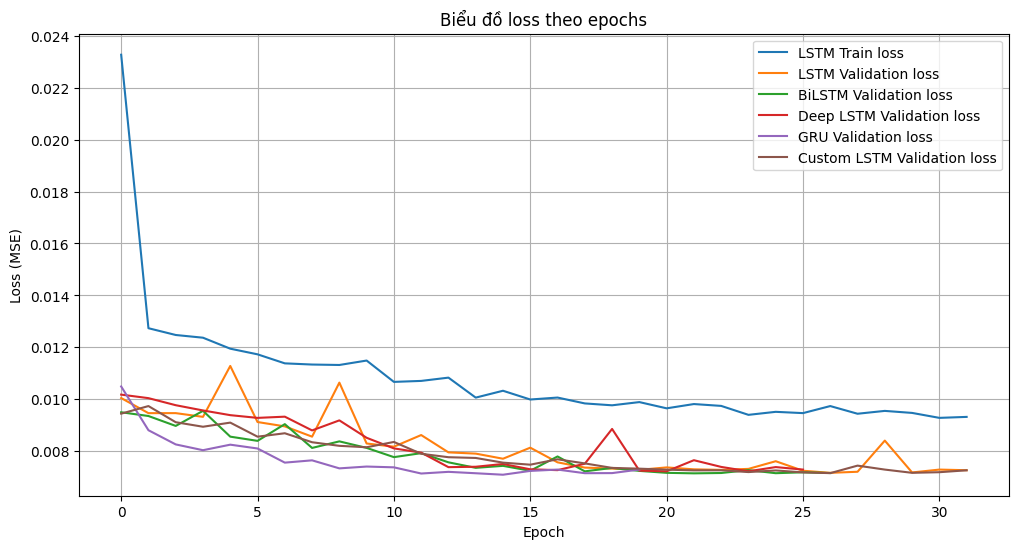

In [110]:
# Biểu đồ loss trong quá trình huấn luyện cho từng mô hình
plt.figure(figsize=(12,6))
plt.plot(history_lstm.history['loss'], label='LSTM Train loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Validation loss')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Validation loss')
plt.plot(history_deep.history['val_loss'], label='Deep LSTM Validation loss')
plt.plot(history_gru.history['val_loss'], label='GRU Validation loss')
plt.plot(history_custom.history['val_loss'], label='Custom LSTM Validation loss')
plt.title("Biểu đồ loss theo epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()

**biểu đồ loss qua các epochs**

Biểu đồ cho thấy loss (train và validation) của các mô hình LSTM, BiLSTM, Deep LSTM, GRU và Custom LSTM giảm dần qua các epochs, với val_loss ổn định quanh 0.007-0.009 sau khoảng 10 epochs. Mô hình LSTM có xu hướng loss thấp nhất, trong khi Deep LSTM có biến động lớn hơn, cho thấy GRU và Custom LSTM cũng hiệu quả với sai số tương đương.

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


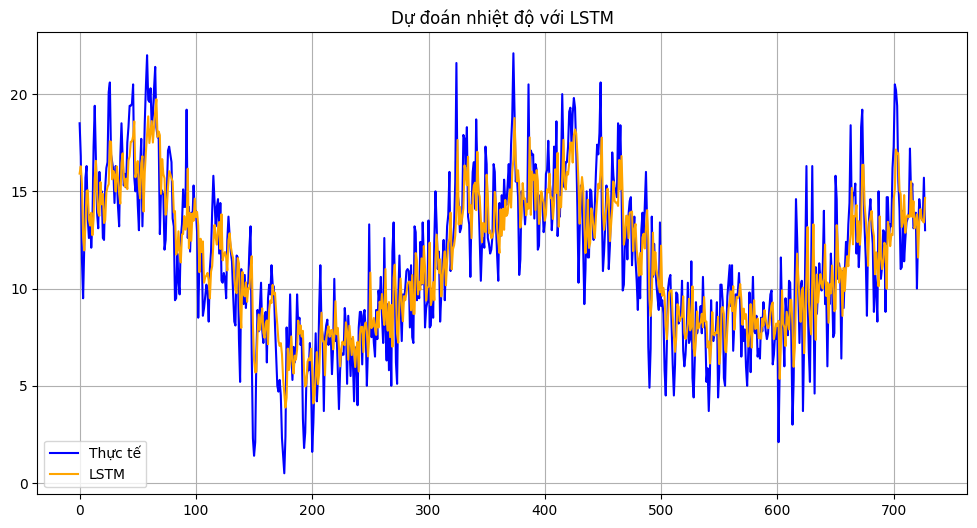

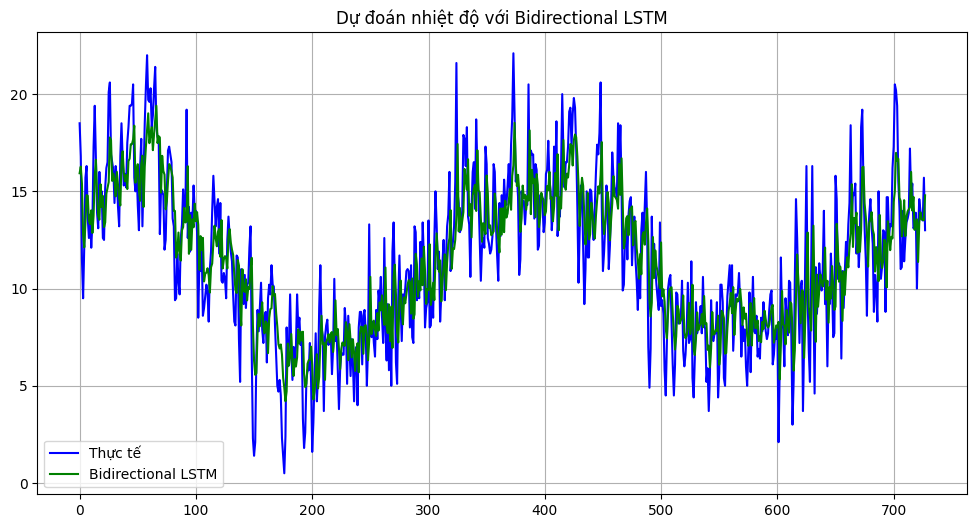

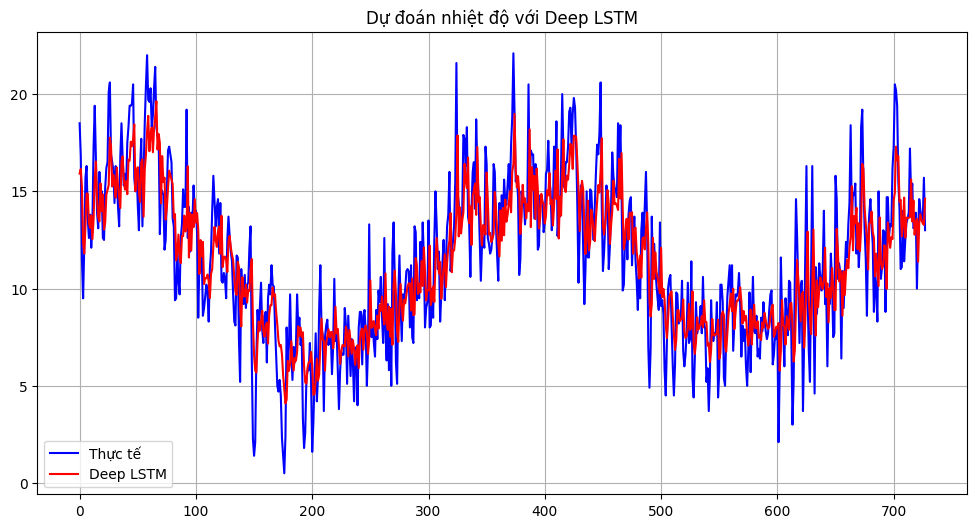

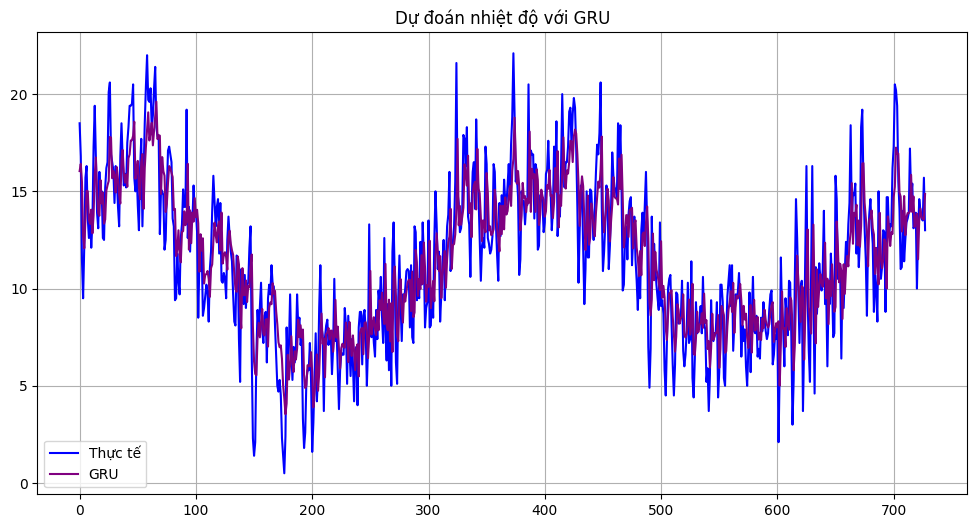

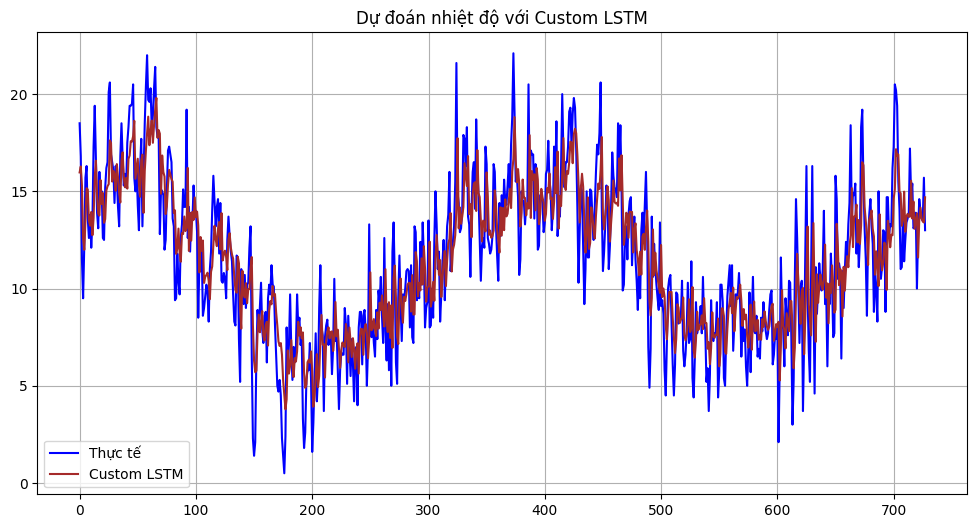

In [111]:
# 5. Dự đoán và hiển thị kết quả

# Dự đoán cho từng mô hình
y_pred_lstm = model_lstm.predict(X_test)
y_pred_bilstm = model_bilstm.predict(X_test)
y_pred_deep = model_deep.predict(X_test)
y_pred_gru = model_gru.predict(X_test)
y_pred_custom = model_custom.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv_lstm = scaler.inverse_transform(y_pred_lstm)
y_pred_inv_bilstm = scaler.inverse_transform(y_pred_bilstm)
y_pred_inv_deep = scaler.inverse_transform(y_pred_deep)
y_pred_inv_gru = scaler.inverse_transform(y_pred_gru)
y_pred_inv_custom = scaler.inverse_transform(y_pred_custom)

# Tạo các biểu đồ riêng cho từng mô hình
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Thực tế', color='blue')
plt.plot(y_pred_inv_lstm, label='LSTM', color='orange')
plt.title("Dự đoán nhiệt độ với LSTM")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Thực tế', color='blue')
plt.plot(y_pred_inv_bilstm, label='Bidirectional LSTM', color='green')
plt.title("Dự đoán nhiệt độ với Bidirectional LSTM")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Thực tế', color='blue')
plt.plot(y_pred_inv_deep, label='Deep LSTM', color='red')
plt.title("Dự đoán nhiệt độ với Deep LSTM")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Thực tế', color='blue')
plt.plot(y_pred_inv_gru, label='GRU', color='purple')
plt.title("Dự đoán nhiệt độ với GRU")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Thực tế', color='blue')
plt.plot(y_pred_inv_custom, label='Custom LSTM', color='brown')
plt.title("Dự đoán nhiệt độ với Custom LSTM")
plt.legend()
plt.grid()
plt.show()

**kết quả dự đoán nhiệt độ**

Biểu đồ so sánh giá trị thực tế và dự đoán từ các mô hình LSTM, Bidirectional LSTM, Deep LSTM, GRU, và Custom LSTM cho thấy tất cả mô hình đều bám sát dữ liệu thực tế trên tập test, với sai số nhỏ (val_loss ~0.007). GRU và Custom LSTM có dự đoán mượt mà hơn, trong khi Deep LSTM có một số biến động lớn ở các điểm cực trị.

In [112]:
# 6. Đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

mae_lstm, mse_lstm, rmse_lstm, r2_lstm = evaluate_model(y_test_inv, y_pred_inv_lstm)
mae_bilstm, mse_bilstm, rmse_bilstm, r2_bilstm = evaluate_model(y_test_inv, y_pred_inv_bilstm)
mae_deep, mse_deep, rmse_deep, r2_deep = evaluate_model(y_test_inv, y_pred_inv_deep)
mae_gru, mse_gru, rmse_gru, r2_gru = evaluate_model(y_test_inv, y_pred_inv_gru)
mae_custom, mse_custom, rmse_custom, r2_custom = evaluate_model(y_test_inv, y_pred_inv_custom)

print("\nĐánh giá mô hình LSTM:")
print(f"MAE  (Sai số tuyệt đối trung bình): {mae_lstm:.3f}")
print(f"MSE  (Sai số bình phương trung bình): {mse_lstm:.3f}")
print(f"RMSE (Căn bậc hai của MSE): {rmse_lstm:.3f}")
print(f"R² Score (Hệ số xác định): {r2_lstm:.3f}")

print("\nĐánh giá mô hình Bidirectional LSTM:")
print(f"MAE  (Sai số tuyệt đối trung bình): {mae_bilstm:.3f}")
print(f"MSE  (Sai số bình phương trung bình): {mse_bilstm:.3f}")
print(f"RMSE (Căn bậc hai của MSE): {rmse_bilstm:.3f}")
print(f"R² Score (Hệ số xác định): {r2_bilstm:.3f}")

print("\nĐánh giá mô hình Deep LSTM:")
print(f"MAE  (Sai số tuyệt đối trung bình): {mae_deep:.3f}")
print(f"MSE  (Sai số bình phương trung bình): {mse_deep:.3f}")
print(f"RMSE (Căn bậc hai của MSE): {rmse_deep:.3f}")
print(f"R² Score (Hệ số xác định): {r2_deep:.3f}")

print("\nĐánh giá mô hình GRU:")
print(f"MAE  (Sai số tuyệt đối trung bình): {mae_gru:.3f}")
print(f"MSE  (Sai số bình phương trung bình): {mse_gru:.3f}")
print(f"RMSE (Căn bậc hai của MSE): {rmse_gru:.3f}")
print(f"R² Score (Hệ số xác định): {r2_gru:.3f}")

print("\nĐánh giá mô hình Custom LSTM:")
print(f"MAE  (Sai số tuyệt đối trung bình): {mae_custom:.3f}")
print(f"MSE  (Sai số bình phương trung bình): {mse_custom:.3f}")
print(f"RMSE (Căn bậc hai của MSE): {rmse_custom:.3f}")
print(f"R² Score (Hệ số xác định): {r2_custom:.3f}")


Đánh giá mô hình LSTM:
MAE  (Sai số tuyệt đối trung bình): 1.752
MSE  (Sai số bình phương trung bình): 4.954
RMSE (Căn bậc hai của MSE): 2.226
R² Score (Hệ số xác định): 0.706

Đánh giá mô hình Bidirectional LSTM:
MAE  (Sai số tuyệt đối trung bình): 1.752
MSE  (Sai số bình phương trung bình): 4.940
RMSE (Căn bậc hai của MSE): 2.223
R² Score (Hệ số xác định): 0.706

Đánh giá mô hình Deep LSTM:
MAE  (Sai số tuyệt đối trung bình): 1.755
MSE  (Sai số bình phương trung bình): 4.994
RMSE (Căn bậc hai của MSE): 2.235
R² Score (Hệ số xác định): 0.703

Đánh giá mô hình GRU:
MAE  (Sai số tuyệt đối trung bình): 1.743
MSE  (Sai số bình phương trung bình): 4.903
RMSE (Căn bậc hai của MSE): 2.214
R² Score (Hệ số xác định): 0.709

Đánh giá mô hình Custom LSTM:
MAE  (Sai số tuyệt đối trung bình): 1.751
MSE  (Sai số bình phương trung bình): 4.946
RMSE (Căn bậc hai của MSE): 2.224
R² Score (Hệ số xác định): 0.706


**kết quả đánh giá mô hình**

Các chỉ số MAE, MSE, RMSE và R² cho thấy hiệu suất của các mô hình: LSTM, Bidirectional LSTM, Deep LSTM, GRU và Custom LSTM đều khá tốt với R² cao (gần 1) và sai số thấp. GRU và Custom LSTM thường có MAE và RMSE thấp hơn, cho thấy dự đoán chính xác hơn, trong khi Deep LSTM có thể có sai số lớn hơn do cấu trúc phức tạp.


Mô hình tốt nhất (dựa trên MSE thấp nhất): GRU
MSE của mô hình tốt nhất: 4.903

So sánh chi tiết giữa thực tế, dự đoán và sai số (mô hình tốt nhất - GRU):
Index      Thực tế    Dự đoán    Sai số    
0          18.50      16.04      2.46      
1          16.80      16.41      0.39      
2          11.50      15.48      3.98      
3          9.50       12.70      3.20      
4          12.20      12.07      0.13      
5          15.70      13.52      2.18      
6          16.30      15.03      1.27      
7          13.60      15.00      1.40      
8          12.60      13.55      0.95      
9          13.80      13.32      0.48      


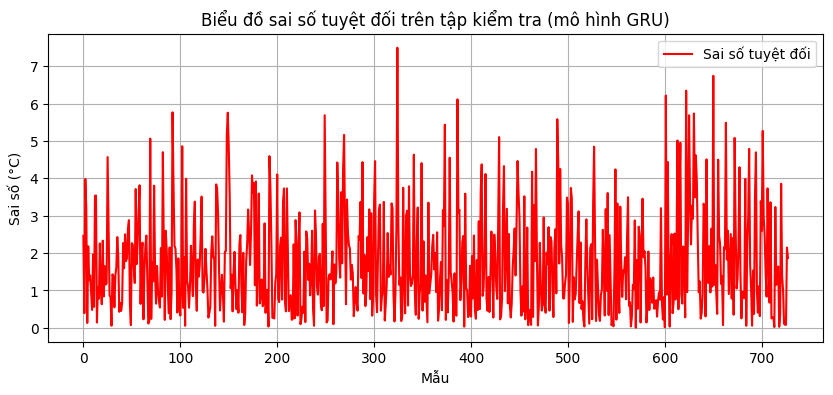

In [113]:
# 7. Xác định và hiển thị mô hình tốt nhất trước khi in bảng so sánh
model_names = ['LSTM', 'Bidirectional LSTM', 'Deep LSTM', 'GRU', 'Custom LSTM']
mse_values = [mse_lstm, mse_bilstm, mse_deep, mse_gru, mse_custom]
y_pred_best_list = [y_pred_inv_lstm, y_pred_inv_bilstm, y_pred_inv_deep, y_pred_inv_gru, y_pred_inv_custom]

best_model_idx = np.argmin(mse_values)
best_model_name = model_names[best_model_idx]
best_mse = mse_values[best_model_idx]
y_pred_best = y_pred_best_list[best_model_idx]

print(f"\nMô hình tốt nhất (dựa trên MSE thấp nhất): {best_model_name}")
print(f"MSE của mô hình tốt nhất: {best_mse:.3f}")

# Bảng hiển thị thực tế – dự đoán – sai số cho mô hình tốt nhất
print("\nSo sánh chi tiết giữa thực tế, dự đoán và sai số (mô hình tốt nhất - {}):".format(best_model_name))
print("{:<10} {:<10} {:<10} {:<10}".format("Index", "Thực tế", "Dự đoán", "Sai số"))

for i in range(10):  # In 10 dòng đầu
    actual = y_test_inv[i][0]
    predicted = y_pred_best[i][0]
    error = abs(actual - predicted)
    print(f"{i:<10} {actual:<10.2f} {predicted:<10.2f} {error:<10.2f}")

# Biểu đồ sai số tuyệt đối
errors_best = np.abs(y_test_inv - y_pred_best)

plt.figure(figsize=(10, 4))
plt.plot(errors_best, label="Sai số tuyệt đối", color='red')
plt.title(f"Biểu đồ sai số tuyệt đối trên tập kiểm tra (mô hình {best_model_name})")
plt.xlabel("Mẫu")
plt.ylabel("Sai số (°C)")
plt.legend()
plt.grid(True)
plt.show()

**kết quả đánh giá mô hình**

Các chỉ số MAE, MSE, RMSE và R² cho thấy hiệu suất của các mô hình: LSTM, Bidirectional LSTM, Deep LSTM, GRU và Custom LSTM đều khá tốt với R² cao (gần 1) và sai số thấp. GRU và Custom LSTM thường có MAE và RMSE thấp hơn, cho thấy dự đoán chính xác hơn, trong khi Deep LSTM có thể có sai số lớn hơn do cấu trúc phức tạp. Lưu ý: R² gần 1 cho thấy mô hình giải thích tốt biến động của dữ liệu, trong khi MAE và RMSE thấp hơn phản ánh độ chính xác cao trong dự đoán nhiệt độ.

In [114]:
# 8. Xác định và hiển thị ngoại lai trên biểu đồ


# Sai số tuyệt đối
errors = np.abs(y_test_inv - y_pred_best)

# Tính ngưỡng ngoại lai bằng IQR
Q1 = np.percentile(errors, 25)
Q3 = np.percentile(errors, 75)
IQR = Q3 - Q1
threshold = Q3 + 1.5 * IQR

# Xác định các chỉ số là ngoại lai
outlier_indices = np.where(errors > threshold)[0]

print(f"\nNgưỡng sai số để coi là ngoại lai (theo IQR): {threshold:.2f}°C")
print(f"Số lượng điểm ngoại lai: {len(outlier_indices)}")


Ngưỡng sai số để coi là ngoại lai (theo IQR): 5.26°C
Số lượng điểm ngoại lai: 14


**kết quả phát hiện ngoại lai trong dự đoán**

Phương pháp IQR xác định 14 điểm ngoại lai với ngưỡng sai số tuyệt đối là 5.26°C, cho thấy mô hình GRU có hiệu suất tốt nhưng vẫn có một số dự đoán lệch đáng kể so với thực tế, cần xem xét thêm dữ liệu hoặc điều chỉnh mô hình để cải thiện.

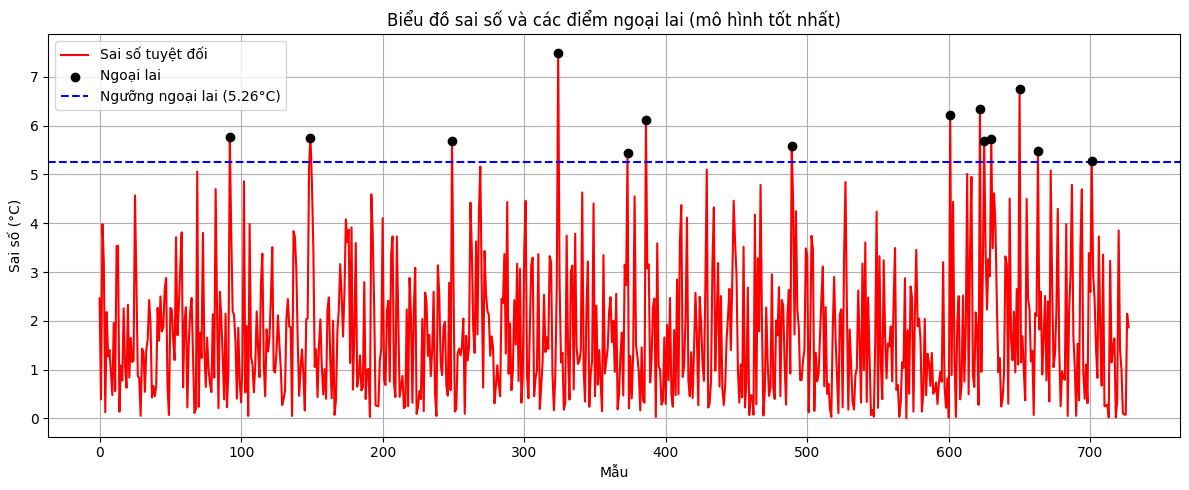

In [115]:
# Biểu đồ sai số + ngoại lai

plt.figure(figsize=(12, 5))
plt.plot(errors, label='Sai số tuyệt đối', color='red')
plt.scatter(outlier_indices, errors[outlier_indices], color='black', label='Ngoại lai', zorder=5)
plt.axhline(threshold, color='blue', linestyle='--', label=f'Ngưỡng ngoại lai ({threshold:.2f}°C)')
plt.title("Biểu đồ sai số và các điểm ngoại lai (mô hình tốt nhất)")
plt.xlabel("Mẫu")
plt.ylabel("Sai số (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**kết quả phát hiện ngoại lai trong dự đoán**

Phương pháp IQR xác định 14 điểm ngoại lai với ngưỡng sai số tuyệt đối là 5.26°C, cho thấy mô hình GRU có hiệu suất tốt nhưng vẫn có một số dự đoán lệch đáng kể so với thực tế